Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of CLIPModel were not initialized from the model checkpoint at ZiyueWang/med-clip and are newly initialized: ['text_model.embeddings.position_embedding.weight', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layer

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3802 - loss: 4.2372 - val_accuracy: 0.7625 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7370 - loss: 0.6730 - val_accuracy: 0.8219 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8268 - loss: 0.4866 - val_accuracy: 0.7937 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8911 - loss: 0.3106 - val_accuracy: 0.7937 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8922 - loss: 0.3000 - val_accuracy: 0.8125 - val_loss: 0.5156 - learning_rate: 5.0000e-04
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9401 - loss: 0.1534 - val_accuracy: 0.7937 - val_loss: 0.5924 - learning_rate: 5.0000e-04
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9728 - loss: 0.1032 - val_ac

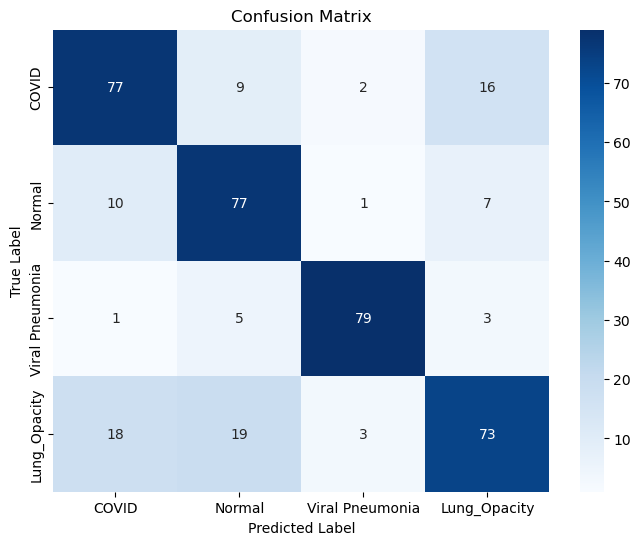

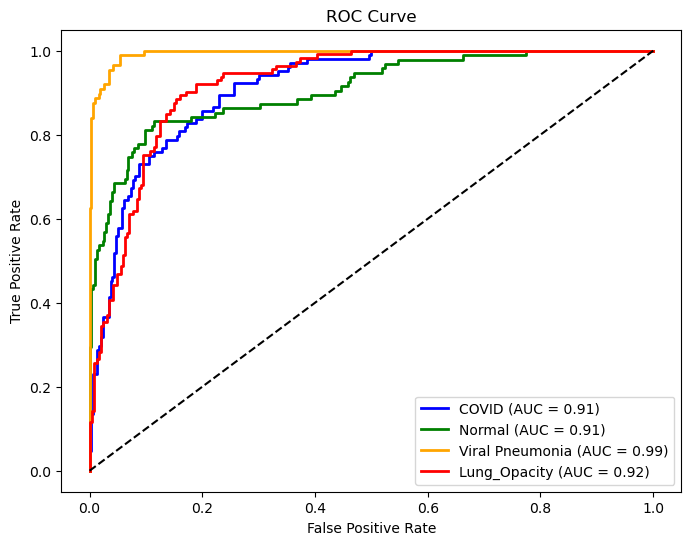

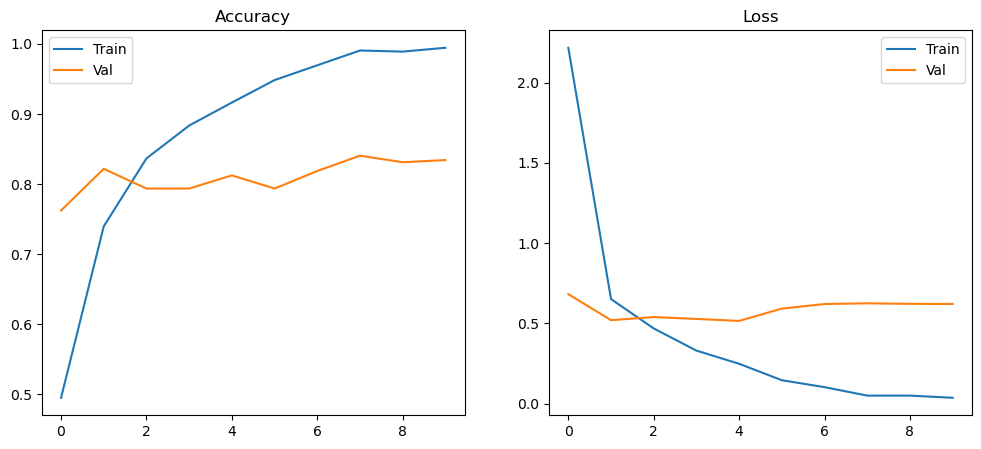

Accuracy: 0.7650
Precision: 0.7679
Recall: 0.7650
F1 Score: 0.7646


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import cv2
import torch
from transformers import AutoProcessor, AutoModel

# Dataset paths and labels
dataset_path = r"C:\Users\Kepav\Downloads\archive\COVID-19_Radiography_Dataset"
categories = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]
label_map = {cat: idx for idx, cat in enumerate(categories)}

# Load MedCLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("ZiyueWang/med-clip")
medclip_model = AutoModel.from_pretrained("ZiyueWang/med-clip").to(device).eval()

def load_images_and_masks(label, sample_size=500, img_size=(224, 224)):
    img_path = os.path.join(dataset_path, label, "images")
    mask_path = os.path.join(dataset_path, label, "masks")
    images, masks, labels = [], [], []
    files = os.listdir(img_path)[:sample_size]
    for file in files:
        image = cv2.imread(os.path.join(img_path, file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            continue
        image = cv2.resize(image, img_size) / 255.0
        mask = cv2.resize(mask, img_size) / 255.0
        stacked = np.stack((image, mask), axis=-1)
        images.append(stacked)
        masks.append(mask)
        labels.append(label_map[label])
    return np.array(images), np.array(masks), np.array(labels)

def convert_to_rgb_and_tensor(mask, img_size=(224, 224)):
    mask = cv2.resize(mask, img_size)
    rgb = np.stack([mask] * 3, axis=-1)
    return rgb

def extract_medclip_embeddings(masks):
    embeddings = []
    for mask in masks:
        rgb = convert_to_rgb_and_tensor(mask)
        inputs = processor(images=rgb, return_tensors="pt", do_rescale=False).to(device)
        with torch.no_grad():
            vision_out = medclip_model.vision_model(pixel_values=inputs["pixel_values"])
            image_embeds = vision_out.pooler_output
        embeddings.append(image_embeds.cpu().numpy().squeeze())
    return np.array(embeddings)

# Load data
X_img_all, X_clip_input_all, y_all = [], [], []
for cat in categories:
    img, mask, label = load_images_and_masks(cat, sample_size=500)
    emb = extract_medclip_embeddings(mask)
    X_img_all.append(img)
    X_clip_input_all.append(emb)
    y_all.append(label)

X_img = np.concatenate(X_img_all)
X_clip = np.concatenate(X_clip_input_all)
y = np.concatenate(y_all)

# Train-test split
X_img_train, X_img_test, X_clip_train, X_clip_test, y_train, y_test = train_test_split(
    X_img, X_clip, y, test_size=0.2, random_state=42)
X_img_train, X_img_val, X_clip_train, X_clip_val, y_train, y_val = train_test_split(
    X_img_train, X_clip_train, y_train, test_size=0.2, random_state=42)

# One-hot
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Fusion Model
img_input = Input(shape=(224, 224, 2))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

clip_input = Input(shape=(X_clip.shape[1],))
c = Dense(256, activation='relu')(clip_input)

combined = Concatenate()([x, c])
z = Dense(256, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[img_input, clip_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
]

history = model.fit(
    [X_img_train, X_clip_train], y_train,
    validation_data=([X_img_val, X_clip_val], y_val),
    epochs=25, batch_size=32, callbacks=callbacks)

# Evaluation
test_loss, test_acc = model.evaluate([X_img_test, X_clip_test], y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = model.predict([X_img_test, X_clip_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'green', 'orange', 'red'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{categories[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()
plt.show()

# Print final metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
